In [3]:

import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.applications.efficientnet import preprocess_input


In [ ]:

# File Paths
csv_path = r"C:\Users\chahi\Desktop\Age_bone_predection\dataset\raw\RSNA\training.csv"
images_folder = r"C:\Users\chahi\Desktop\Age_bone_predection\dataset\raw\RSNA\boneage-training-dataset"


# Load the CSV
df = pd.read_csv(csv_path)

# Extract columns
image_ids = df["id"].astype(str)  # Convert to string
boneages = df["boneage"].values   # Bone age labels
sexes = df["male"].values         # Sex labels (0 = Female, 1 = Male)

# Detect hand orientation
def detect_hand_orientation(image):
    """Corrects hand orientation to point upwards."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 30, 100)  # Edge detection
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=15)

    if lines is None:
        return image  # No adjustment needed

    angles = [np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi for x1, y1, x2, y2 in lines[:, 0]]
    median_angle = np.median(angles)

    # Normalize the angle
    if median_angle < -60:
        median_angle += 90
    elif median_angle > 60:
        median_angle -= 90

    # Rotation
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT)

    return rotated

# Crop hand region
def crop_hand_region(image):
    """Removes background and crops the hand."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image  # No cropping needed

    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return image[y:y+h, x:x+w]

# Resize image with padding
def resize_image(image, target_size=(224, 224)):
    """Resize the image while maintaining the aspect ratio."""
    h, w = image.shape[:2]

    # Check for valid dimensions
    if h == 0 or w == 0:
        print(f"Error: Invalid image dimensions (h={h}, w={w}).")
        return None

    # Scale factor to maintain aspect ratio
    scale = min(target_size[0] / w, target_size[1] / h)
    new_w = max(1, int(w * scale))
    new_h = max(1, int(h * scale))

    # Resize the image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Add padding to reach target size
    delta_w = target_size[0] - new_w
    delta_h = target_size[1] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded

# Preprocess a single image
def preprocess_image(image_path):
    """Pipeline complet de prétraitement."""
    # Chargement en RGB
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Étapes critiques
    image = detect_hand_orientation(image)
    image = crop_hand_region(image)
    image = resize_image(image)             # Resize with padding

    return image

# Processing du dataset
X_data, y_age, y_sex = [], [], []

with tqdm(total=len(image_ids), desc="Prétraitement") as pbar:
    for img_id, age, sex in zip(image_ids, boneages, sexes):
        img_path = os.path.join(images_folder, f"{img_id}.png")
        processed_img = preprocess_image(img_path)
        
        if processed_img is not None:
            X_data.append(processed_img)
            y_age.append(age)
            y_sex.append(sex)
        pbar.update(1)  # Mise à jour explicite

print(f"\nDonnées sauvegardées : {len(X_data)} images traitées !")

# Conversion et sauvegarde
X_data = np.array(X_data).astype(np.uint8)
y_age = np.array(y_age)
y_sex = np.array(y_sex)

output_dir =r'C:\Users\chahi\Desktop\Age_bone_predection\dataset\Processed'
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "images.npy"), X_data)
np.save(os.path.join(output_dir, "ages.npy"), y_age)
np.save(os.path.join(output_dir, "sexes.npy"), y_sex)

print(" Données sauvegardées dans le répertoire npy_files !")



Prétraitement: 100%|██████████| 12611/12611 [20:55<00:00, 10.04it/s]



Données sauvegardées : 12611 images traitées !
 Données sauvegardées dans le répertoire npy_files !


: 

In [ ]:
def prepare_datasets(data_dir, batch_size=32, val_split=0.2, augment=True):
    # Chargement des données
    images = np.load(os.path.join(data_dir, "images.npy"))
    ages = np.load(os.path.join(data_dir, "ages.npy"))
    sexes = np.load(os.path.join(data_dir, "sexes.npy"))
    
    # Normalisation EfficientNet
    images = preprocess_input(images.astype(np.float32))
    
    # Normalisation de l'âge
    age_mean = np.mean(ages)
    age_std = np.std(ages)
    ages = (ages - age_mean) / age_std
    
    # Création du dataset avec structure ((image, sex), age)
    dataset = tf.data.Dataset.from_tensor_slices(((images, sexes), ages))
    
    # Shuffle avant le split
    dataset = dataset.shuffle(1000, seed=42)
    
    # Calcul de la taille de validation
    val_size = int(len(images) * val_split)
    train_size = len(images) - val_size
    
    # Split du dataset
    train_ds = dataset.skip(val_size)
    val_ds = dataset.take(val_size)
    
    # Définition de l'augmentation
    def augment_data(image, sex, age):
        # Augmentations d'image uniquement
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return (image, sex), age
    
    # Application de l'augmentation seulement au train set
    if augment:
        train_ds = train_ds.map(
            lambda x, y: augment_data(x[0], x[1], y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Batch et optimisation des performances
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, age_mean, age_std

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, concatenate
from tensorflow.keras.applications import EfficientNetB0

def build_model():
    # Entrée image
    img_input = Input(shape=(224, 224, 3))
    # Backbone EfficientNet
    base_model = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_tensor=img_input
    )
    base_model.trainable = False  # Freeze initial
    # Feature extraction
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    # Entrée sexe
    sex_input = Input(shape=(1,))
    sex_feature = Dense(8, activation='relu')(sex_input)
    # Fusion
    merged = concatenate([x, sex_feature])
    merged = Dropout(0.3)(merged)
    # Régression
    output = Dense(1)(merged)
    # Modèle final
    model = Model(inputs=[img_input, sex_input], outputs=output)
    
    # Compilation
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Utilisation
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,692 (16.07 MB)

 Trainable params: 164,121 (641.10 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
#plots etude de l'entrainement
import matplotlib.pyplot as plt
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'efficientnet - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'efficientnet - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')

    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - loss: 0.8933 - mae: 0.7373
Epoch 1: val_mae improved from inf to 0.49978, saving model to best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 242s 953ms/step - loss: 0.8923 - mae: 0.7369 - val_loss: 0.4234 - val_mae: 0.4998 - learning_rate: 0.0010
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - loss: 0.4894 - mae: 0.5476
Epoch 2: val_mae improved from 0.49978 to 0.43116, saving model to best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 176s 744ms/step - loss: 0.4893 - mae: 0.5475 - val_loss: 0.3261 - val_mae: 0.4312 - learning_rate: 0.0010
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - loss: 0.4488 - mae: 0.5159
Epoch 3: val_mae improved from 0.43116 to 0.41279, saving model to best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 168s 708ms/step - loss: 0.4488 - mae: 0.5158 - val_loss: 0.2960 - val_mae: 0.4128 - learning_rate: 0.0010
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 0.4130 - mae: 0.4985
Epoch 4: val_mae did not improve from 0.41279
237/237 ━━━━━━━━━━━━━━━━━━━━ 171s 723ms/step - loss: 0.4130 - mae: 0.4985 - val_loss: 0.3179 - val_mae: 0.4281 - learning_rate: 0.0010
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - loss: 0.4062 - mae: 0.4930
Epoch 5: val_mae did not improve from 0.41279
237/237 ━━━━━━━━━━━━━━━━━━━━ 168s 708ms/step - loss: 0.4061 - mae: 0.4930 - val_loss: 0.3109 - val_mae: 0.4244 - learning_rate: 0.0010
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - loss: 0.3898 - mae: 0.4830
Epoch 6: val_mae improved from 0.41279 to 0.39392, saving model to best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 170s 715ms/step - loss: 0.3898 - mae: 0.4830 - val_loss: 0.2809 - val_mae: 0.3939 - learning_rate: 0.0010
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.3909 - mae: 0.4832
Epoch 7: val_mae did not improve from 0.39392
237/237 ━━━━━━━━━━━━━━━━━━━━ 146s 615ms/step - loss: 0.3909 - mae: 0.4832 - val_loss: 0.2930 - val_mae: 0.4037 - learning_rate: 0.0010
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 0.3961 - mae: 0.4885
Epoch 8: val_mae did not improve from 0.39392
237/237 ━━━━━━━━━━━━━━━━━━━━ 135s 571ms/step - loss: 0.3960 - mae: 0.4885 - val_loss: 0.2762 - val_mae: 0.3943 - learning_rate: 0.0010
Epoch 9/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 0.3826 - mae: 0.4715
Epoch 9: val_mae improved from 0.39392 to 0.38425, saving model to best_model.h5


237/237 ━━━━━━━━━━━━━━━━━━━━ 143s 605ms/step - loss: 0.3825 - mae: 0.4715 - val_loss: 0.2671 - val_mae: 0.3843 - learning_rate: 0.0010
Epoch 10/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 0.3831 - mae: 0.4739
Epoch 10: val_mae did not improve from 0.38425
237/237 ━━━━━━━━━━━━━━━━━━━━ 135s 570ms/step - loss: 0.3830 - mae: 0.4739 - val_loss: 0.2709 - val_mae: 0.3997 - learning_rate: 0.0010
Epoch 11/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 0.3638 - mae: 0.4670
Epoch 11: val_mae did not improve from 0.38425
237/237 ━━━━━━━━━━━━━━━━━━━━ 134s 566ms/step - loss: 0.3638 - mae: 0.4670 - val_loss: 0.2710 - val_mae: 0.3930 - learning_rate: 0.0010
Epoch 12/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.3622 - mae: 0.4655
Epoch 12: val_mae did not improve from 0.38425
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 599ms/step - loss: 0.3622 - mae: 0.4655 - val_loss: 0.2837 - val_mae: 0.4038 - learning_rate: 0.0010
Epoch 13/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 0.38

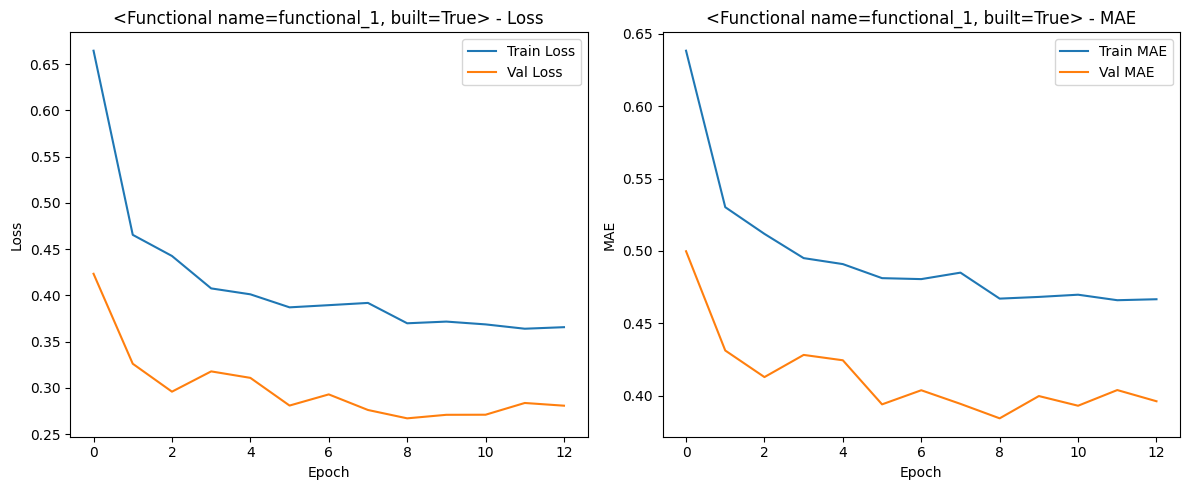

In [9]:
# 1. Préprocess et sauvegarde des données
# (Exécuter une seule fois)
# preprocess_and_save_data()

# 2. Chargement des données
data_dir = r"C:\Users\chahi\Desktop\Age_bone_predection\dataset\splits"
train_ds, val_ds, age_mean, age_std = prepare_datasets( data_dir, batch_size=32, augment=True )

# 3. Entraînement
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
def train_model(model, train_ds, val_ds, epochs=50):
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=4,
            verbose=1,
            restore_best_weights=True,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_model.h5',
            save_best_only=True,
            monitor='val_mae',
            mode='min',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Utilisation
model = build_model()
history = train_model(model, train_ds, val_ds)
plot_training_history(history, model)

In [ ]:
model.save('bone_age_model_efficientnet.keras')

In [6]:
def prepare_datasets(data_dir, batch_size=32, val_split=0.2, augment=True):
    # Chargement des données
    images = np.load(os.path.join(data_dir, "images_eval.npy"))
    ages = np.load(os.path.join(data_dir, "ages_eval.npy"))
    sexes = np.load(os.path.join(data_dir, "sexes_eval.npy"))
    
    # Normalisation EfficientNet
    images = preprocess_input(images.astype(np.float32))
    
    # Normalisation de l'âge
    age_mean = np.mean(ages)
    age_std = np.std(ages)
    ages = (ages - age_mean) / age_std
    
    # Création du dataset avec structure ((image, sex), age)
    dataset = tf.data.Dataset.from_tensor_slices(((images, sexes), ages))
    
    # Shuffle avant le split
    dataset = dataset.shuffle(1000, seed=42)
    
    # Calcul de la taille de validation
    val_size = int(len(images) * val_split)
    train_size = len(images) - val_size
    
    # Split du dataset
    train_ds = dataset.skip(val_size)
    val_ds = dataset.take(val_size)
    
    # Définition de l'augmentation
    def augment_data(image, sex, age):
        # Augmentations d'image uniquement
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return (image, sex), age
    
    # Application de l'augmentation seulement au train set
    if augment:
        train_ds = train_ds.map(
            lambda x, y: augment_data(x[0], x[1], y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Batch et optimisation des performances
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, age_mean, age_std

MAE: 15.64 mois
MSE: 20.27 mois
R²: 0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


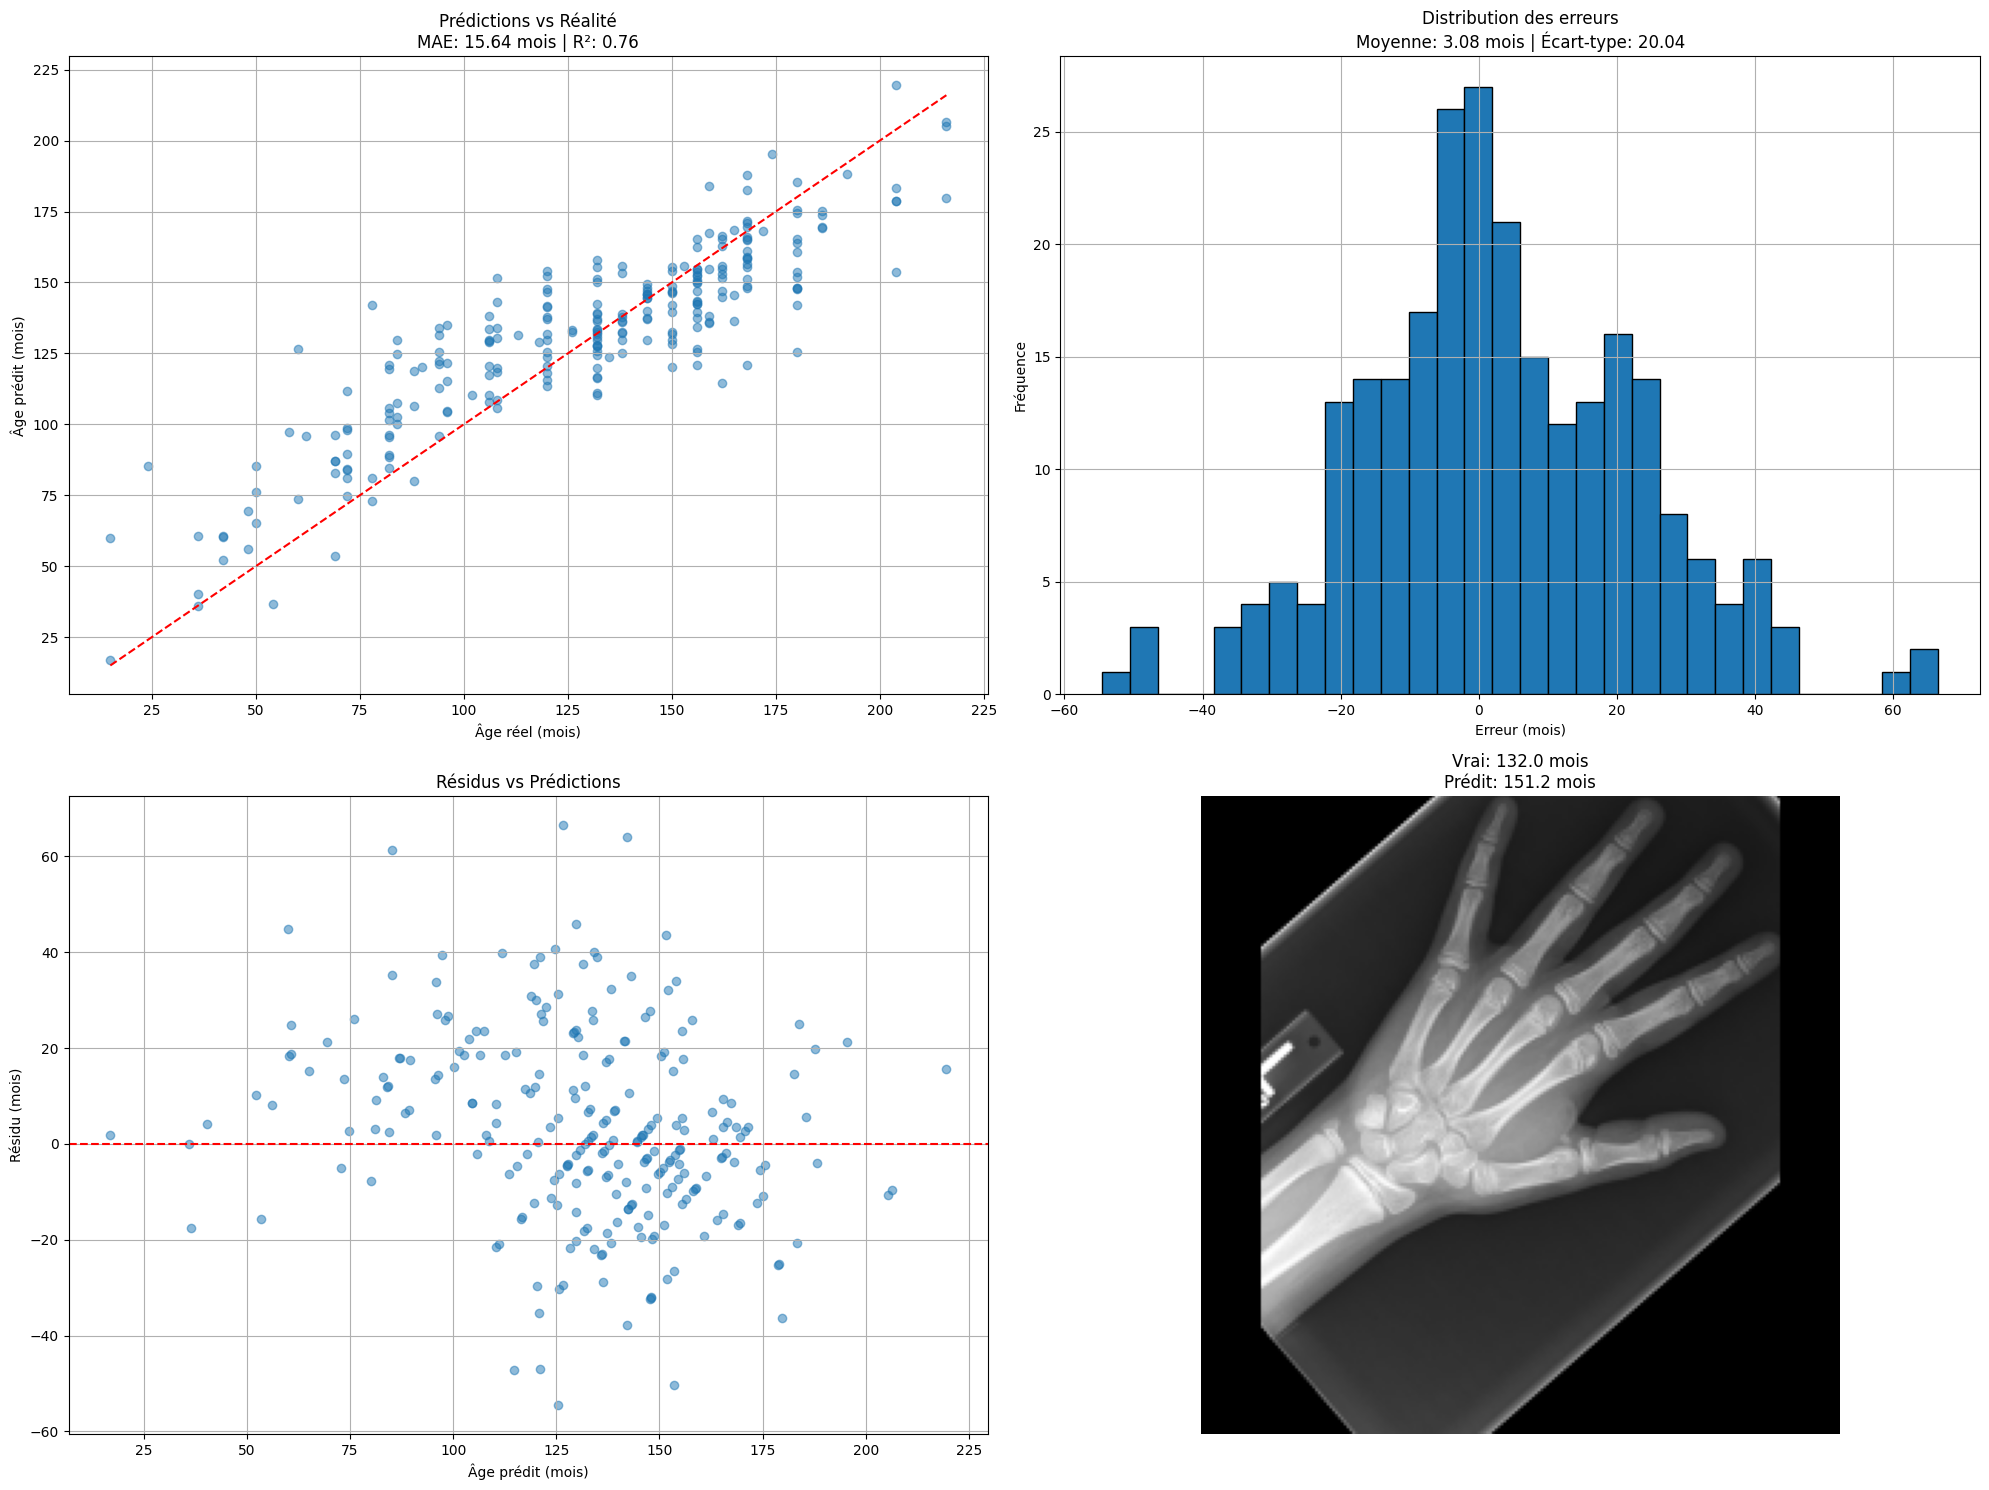

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, dataset, age_mean, age_std):
    # Prédictions
    y_true = []
    y_pred = []
    
    for (images, sexes), ages in dataset:
        preds = model.predict([images, sexes], verbose=0)
        y_true.extend(ages.numpy())
        y_pred.extend(preds.squeeze())
    
    # Dénormalisation
    y_true = np.array(y_true) * age_std + age_mean
    y_pred = np.array(y_pred) * age_std + age_mean
    
    # Calcul des métriques
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"MAE: {mae:.2f} mois")
    print(f"MSE: {rmse:.2f} mois")
    print(f"R²: {r2:.2f}")

    # Visualisations
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Prédictions vs Réalité
    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Âge réel (mois)')
    plt.ylabel('Âge prédit (mois)')
    plt.title(f'Prédictions vs Réalité\nMAE: {mae:.2f} mois | R²: {r2:.2f}')
    plt.grid(True)

    # Plot 2: Distribution des erreurs
    plt.subplot(2, 2, 2)
    errors = y_pred - y_true
    plt.hist(errors, bins=30, edgecolor='black')
    plt.xlabel('Erreur (mois)')
    plt.ylabel('Fréquence')
    plt.title(f'Distribution des erreurs\nMoyenne: {errors.mean():.2f} mois | Écart-type: {errors.std():.2f}')
    plt.grid(True)

    # Plot 3: Résidus vs Prédictions
    plt.subplot(2, 2, 3)
    plt.scatter(y_pred, errors, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Âge prédit (mois)')
    plt.ylabel('Résidu (mois)')
    plt.title('Résidus vs Prédictions')
    plt.grid(True)

    # Plot 4: Exemples d'images avec prédictions
    plt.subplot(2, 2, 4)
    for i in np.random.choice(len(dataset), 4):  # 4 exemples aléatoires
        (image, sex), true_age = next(iter(dataset.skip(i).take(1)))
        pred_age = model.predict([np.expand_dims(image[0], 0), np.expand_dims(sex[0], 0)])[0][0]
        pred_age = pred_age * age_std + age_mean
        true_age = true_age.numpy()[0] * age_std + age_mean
        
        plt.subplot(2, 2, 4)
        plt.imshow(image[0].numpy().astype(np.uint8))
        plt.title(f"Vrai: {true_age:.1f} mois\nPrédit: {pred_age:.1f} mois")
        plt.axis('off')
        break  # Affiche juste un exemple pour simplifier
    
    plt.tight_layout()
    plt.show()

# Utilisation
model = tf.keras.models.load_model('bone_age_model_efficientnet.keras')  # Charger votre meilleur modèle
_, eval_ds, age_mean, age_std = prepare_datasets(r"C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\dataset\splits", augment=False)

evaluate_model(model, eval_ds, age_mean, age_std)



C:\Users\chahi\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Performance Globale:
- MAE: 15.88 mois
- RMSE: 21.26 mois
- R²: 0.74

Performance Femme (n=847):
- MAE: 17.01 mois
- RMSE: 22.17 mois
- R²: 0.67
--------------------------------------------------
Performance Homme (n=1044):
- MAE: 14.96 mois
- RMSE: 20.49 mois
- R²: 0.76
--------------------------------------------------


C:\Users\chahi\AppData\Local\Temp\ipykernel_12692\587102639.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_data, labels=sex_label_map.values())


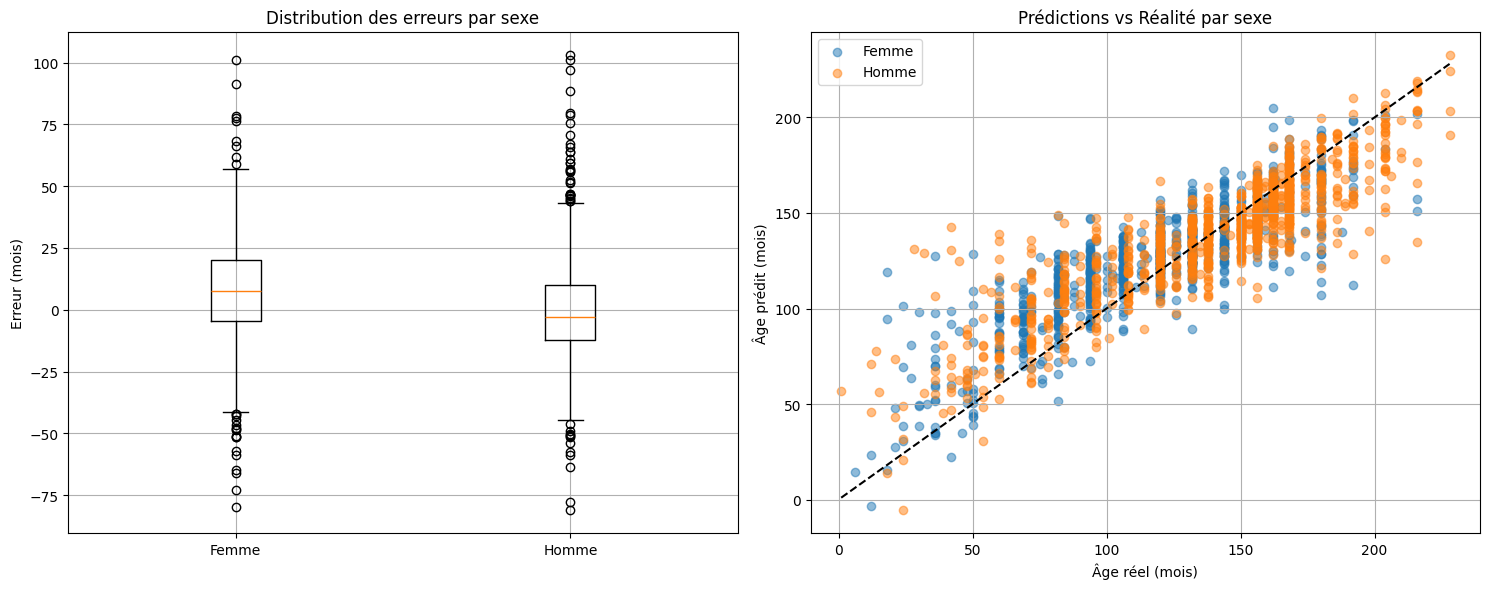

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model_bysexe(model, dataset, age_mean, age_std, sex_label_map={0: 'Femme', 1: 'Homme'}):
    """
    Évalue le modèle et analyse les performances par sexe
    Args:
        sex_label_map: Dictionnaire de mapping des valeurs de sexe
    """
    # Collecte des données
    y_true = []
    y_pred = []
    sexes = []
    
    for (images, batch_sexes), batch_ages in dataset:
        batch_preds = model.predict([images, batch_sexes], verbose=0).squeeze()
        y_true.extend(batch_ages.numpy())
        y_pred.extend(batch_preds)
        sexes.extend(batch_sexes.numpy())
    
    # Conversion en arrays numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    sexes = np.array(sexes)
    
    # Dénormalisation
    y_true = y_true * age_std + age_mean
    y_pred = y_pred * age_std + age_mean

    # Calcul des métriques globales
    global_mae = mean_absolute_error(y_true, y_pred)
    global_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    global_r2 = r2_score(y_true, y_pred)

    # Analyse par sexe
    results = {}
    for sex_value, sex_label in sex_label_map.items():
        mask = sexes == sex_value
        if np.sum(mask) == 0:
            continue
            
        results[sex_label] = {
            'mae': mean_absolute_error(y_true[mask], y_pred[mask]),
            'rmse': np.sqrt(mean_squared_error(y_true[mask], y_pred[mask])),
            'r2': r2_score(y_true[mask], y_pred[mask]),
            'count': np.sum(mask)
        }

    # Affichage des résultats
    print("="*50)
    print(f"Performance Globale:")
    print(f"- MAE: {global_mae:.2f} mois")
    print(f"- RMSE: {global_rmse:.2f} mois")
    print(f"- R²: {global_r2:.2f}\n")
    
    for sex_label, metrics in results.items():
        print(f"Performance {sex_label} (n={metrics['count']}):")
        print(f"- MAE: {metrics['mae']:.2f} mois")
        print(f"- RMSE: {metrics['rmse']:.2f} mois")
        print(f"- R²: {metrics['r2']:.2f}")
        print("-"*50)

    # Visualisation
    plt.figure(figsize=(15, 6))
    
    # Boxplot des erreurs
    plt.subplot(1, 2, 1)
    error_data = [y_pred[sexes == s] - y_true[sexes == s] for s in sex_label_map.keys()]
    plt.boxplot(error_data, labels=sex_label_map.values())
    plt.title('Distribution des erreurs par sexe')
    plt.ylabel('Erreur (mois)')
    plt.grid(True)

    # Scatter plot coloré par sexe
    plt.subplot(1, 2, 2)
    for sex_value, sex_label in sex_label_map.items():
        mask = sexes == sex_value
        plt.scatter(y_true[mask], y_pred[mask], alpha=0.5, label=sex_label)
    
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Âge réel (mois)')
    plt.ylabel('Âge prédit (mois)')
    plt.title('Prédictions vs Réalité par sexe')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return results

# Charger les données et le modèle
model = tf.keras.models.load_model('bone_age_model_efficientnet.keras')
_, eval_ds, age_mean, age_std = prepare_datasets(data_dir, augment=False)

# Appeler la fonction
results = evaluate_model_bysexe(model, eval_ds, age_mean, age_std)